<a href="https://colab.research.google.com/github/Bendidi/My_python/blob/main/arabizi_WE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch transformers pandas numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install tqdm

Import necessary modules

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Data Preprocessing

In [3]:
class DarijaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 2. LSTM Classifier

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, bert_hidden_size=768, lstm_hidden_size=256, num_layers=2, dropout=0.2):
        super(LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=bert_hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden_size * 2, 2)  # 2 for binary classification

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out

# 3. Training Functions

In [5]:
def get_bert_embeddings(text_batch, bert_model, tokenizer, device):

    text_batch = tokenizer.batch_decode(text_batch, skip_special_tokens=True)
    inputs = tokenizer(
        text_batch,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state

    return embeddings

def train_epoch(model, dataloader, criterion, optimizer, bert_model, tokenizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        texts = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Get BERT embeddings
        embeddings = get_bert_embeddings(texts, bert_model, tokenizer, device)

        # Forward pass
        outputs = model(embeddings)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, bert_model, tokenizer, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            texts = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            embeddings = get_bert_embeddings(texts, bert_model, tokenizer, device)
            outputs = model(embeddings)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    return predictions, actual_labels

# 4. Main Training Pipeline

In [8]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your dataset
    # Assuming your data is in a CSV file with 'text' and 'label' columns
    # Replace 'your_dataset.csv' with actual file path
    df = pd.read_csv('arabizi_data.csv')

    # Convert labels to binary (0 for negative, 1 for positive)
    df['polarity'] = (df['polarity'] == '1').astype(int)

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['comment'].values, df['polarity'].values,
        test_size=0.2, random_state=42
    )

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT-arabizi")
    bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT-arabizi").to(device)

    # Create datasets
    train_dataset = DarijaDataset(train_texts, train_labels, tokenizer)
    val_dataset = DarijaDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model and training components
    model = LSTMClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    # Training loop
    num_epochs = 5
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_epoch(
            model, train_loader, criterion, optimizer,
            bert_model, tokenizer, device
        )

        # Evaluate
        val_preds, val_labels = evaluate(
            model, val_loader, bert_model, tokenizer, device
        )

        # Print metrics
        print(f"\nTraining Loss: {train_loss:.4f}")
        print("\nValidation Results:")
        print(classification_report(val_labels, val_preds))

        # Save best model
        val_accuracy = (np.array(val_preds) == np.array(val_labels)).mean()
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')

    # Plot confusion matrix for best model
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(val_labels, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT-arabizi and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Evaluating: 100%|██████████| 34/34 [00:04<00:00,  8.32it/s]



Training Loss: 0.5155

Validation Results:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       366
           1       0.85      0.98      0.91       702

    accuracy                           0.87      1068
   macro avg       0.89      0.82      0.84      1068
weighted avg       0.88      0.87      0.86      1068


Epoch 2/5


Evaluating: 100%|██████████| 34/34 [00:03<00:00,  8.84it/s]



Training Loss: 0.2279

Validation Results:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       366
           1       0.93      0.94      0.94       702

    accuracy                           0.92      1068
   macro avg       0.91      0.91      0.91      1068
weighted avg       0.92      0.92      0.92      1068


Epoch 3/5


Evaluating: 100%|██████████| 34/34 [00:03<00:00,  8.99it/s]



Training Loss: 0.1501

Validation Results:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       366
           1       0.95      0.94      0.95       702

    accuracy                           0.93      1068
   macro avg       0.92      0.93      0.92      1068
weighted avg       0.93      0.93      0.93      1068


Epoch 4/5


Evaluating: 100%|██████████| 34/34 [00:03<00:00,  8.81it/s]



Training Loss: 0.1248

Validation Results:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       366
           1       0.95      0.95      0.95       702

    accuracy                           0.94      1068
   macro avg       0.93      0.93      0.93      1068
weighted avg       0.94      0.94      0.94      1068


Epoch 5/5


Evaluating: 100%|██████████| 34/34 [00:03<00:00,  8.69it/s]



Training Loss: 0.0985

Validation Results:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       366
           1       0.96      0.95      0.96       702

    accuracy                           0.94      1068
   macro avg       0.94      0.94      0.94      1068
weighted avg       0.94      0.94      0.94      1068



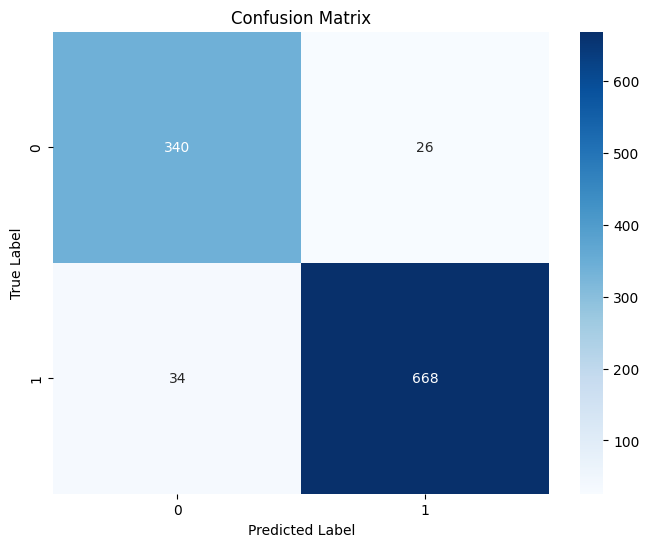

In [9]:
if __name__ == "__main__":
    main()